In [ ]:
!pip install  "git+https://github.com/meguia/acousticfield"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/meguia/acousticfield to /tmp/pip-req-build-ia1y0flj
  Running command git clone -q https://github.com/meguia/acousticfield /tmp/pip-req-build-ia1y0flj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for acousticfield: filename=acousticfield-0.0.6-py3-none-any.whl size=19731 sha256=eee2ca73306657e9db1150481d3eff19151e469c0170d9f34c908e8d920c4170
  Stored in directory: /tmp/pip-ephem-wheel-cache-a42tt0tr/wheels/13/cf/7a/8687dda0a6b0b8ce24e2c0ffe6c1cf3a785c782cbd314d4b06
Successfully built acousticfield


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.special import expit, logit
from scipy.signal import convolve, lfilter
from scipy.signal import savgol_filter
from scipy.io import wavfile

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (28, 6)

In [ ]:
from acousticfield.generate import sweep, whitenoise
from acousticfield.process import ir_extract, spectrum
from acousticfield.display import *

In [ ]:
fs=192000

In [ ]:
rpath = "/content/drive/Shareddrives/LAPSo_EXT/Parlantes/"

# Grabacion de las RI de los parlantes 
Se ejecuto solo una vez, lo dejamos como control y registro de lo que se hizo y como se hizo

Si los estimulos ya estan generados dejar estas celdas comentadas

In [ ]:
#wn = whitenoise(3.0, flow=40, fhigh=20000, nchannels=1, fadein=0.05, fadeout=0.05, fs=fs,filename=rpath+"wnoise")
#rms_wn = 10*np.log10(np.mean(np.square(wn)))
#print(rms_wn)

-13.600868583040477


/usr/local/lib/python3.7/dist-packages/acousticfield/generate.py:109: RuntimeWarning: overflow encountered in exp
  sig = np.where(x1 < 0, np.exp(x1)/(1 + np.exp(x1)), 1/(1 + np.exp(-x1)))
/usr/local/lib/python3.7/dist-packages/acousticfield/generate.py:109: RuntimeWarning: invalid value encountered in true_divide
  sig = np.where(x1 < 0, np.exp(x1)/(1 + np.exp(x1)), 1/(1 + np.exp(-x1)))


Aca generamos un sweep que tenga la misma RMS que el ruido anterior (o un nivel menosr tomando el ruido como referencia), para poder medir la RI a diferentes intensidades, lo hicimos a -13, -23 y -33 dB

In [ ]:
#sweep2 = sweep(T=30,fs=fs,f1=30,f2=24000,Nrep=1,filename=rpath+'sweep_192kHz_30s_30_24k_33dB',post=1.0,rms=rms_wn-20)

Warning RMS pedido mayor al RMS de corte que es -3.45 dB 
Sweep RMS = -3.45 dB 
Sweep generated with 1008000 samples.
Total signal with 1 repetitions has a duration of 21.00 seconds


In [ ]:
parlantes = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']
rms = ['13','23','33']
nparlantes = len(parlantes)
nrms = len(rms)

In [ ]:
tmin = 0.0005
nmin = int(tmin*fs)
nmax = nmin+1024
t = 1000*np.arange(nmin,nmax)/fs

In [ ]:
# SE corre solo una vez!
ri_all = np.zeros((nmax-nmin,nparlantes,nrms))
for n in range(nrms):
  for m in range(nparlantes):
    #print(parlante + '_' + rms[m])
    invfile = rpath + 'sweep_192kHz_30s_30_24k_' + rms[n] + 'dB'
    recfile = rpath + 'rec_' + parlantes[m] + '_' + rms[n]
    ri_temp = ir_extract(recfile,invfile,rpath + 'ri_' + parlantes[m] + rms[n],loopback=1,fs=fs)
    rms_dir = 20*np.log10(np.mean(np.abs(ri_temp[nmin:nmax,0])))
    ri_all[:,m,n] = ri_temp[nmin:nmax,0]

np.save(rpath + 'ri_all.npy',ri_all)

/usr/local/lib/python3.7/dist-packages/acousticfield/process.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(rec + '.wav')


In [ ]:
TF_all = np.zeros((513,nparlantes,nrms))
for n in range(nrms):
  for m in range(nparlantes):
    TF = spectrum(ri_all[:,m,n], fs=fs);
    # normalizacion trucha entre 0 y 20 k
    smean = np.mean(TF['s'][0,:110])
    np.save(rpath + "TF_" + parlantes[m] + "_" + rms[n] + ".npy",TF)
    TF_all[:,m,n] = TF['s'][0,:]-smean

# Filtro inverso
 Lo hacemos para la grabacion a 13 dB
 el primer paso es copiar el array y generar un array y alinearlo con el pico maximo

In [ ]:
ri_all = np.load(rpath + 'ri_all.npy')

In [ ]:
ri_all_13=ri_all[:,:,0]
N = ri_all.shape[0]
df = fs/N
f = np.arange(N)*df

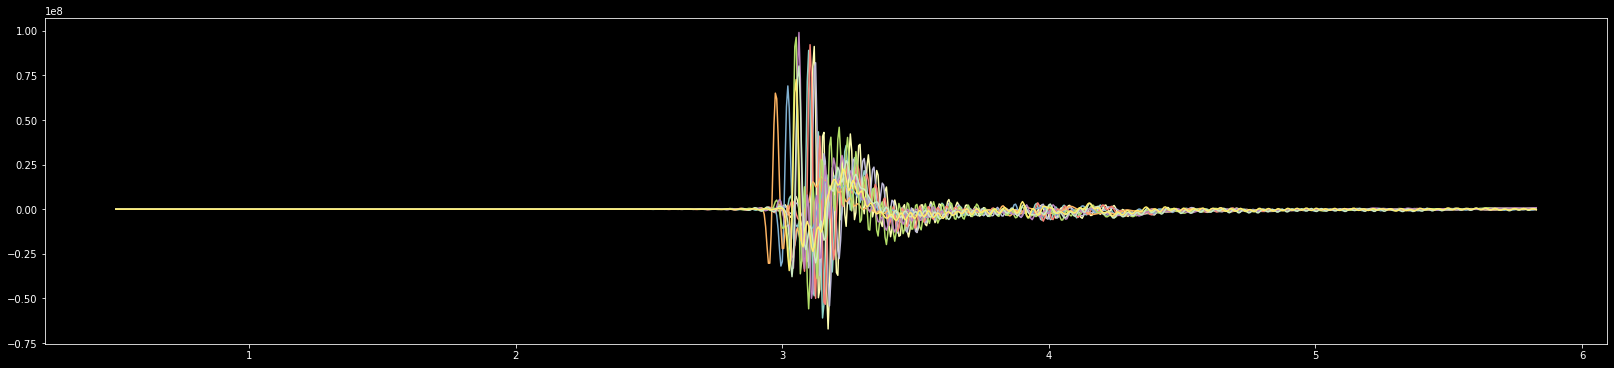

In [ ]:
plt.plot(t,ri_all_13);

In [ ]:
# alineamos las RI por el maximo del pico
nmaxv = np.argmax(ri_all_13,axis=0)
leftm = min(nmaxv)-1
rightm = 1024-max(nmaxv)-1
ncommon = ri_all_13[nmaxv[0]-leftm:nmaxv[0]+rightm,0].shape[0]

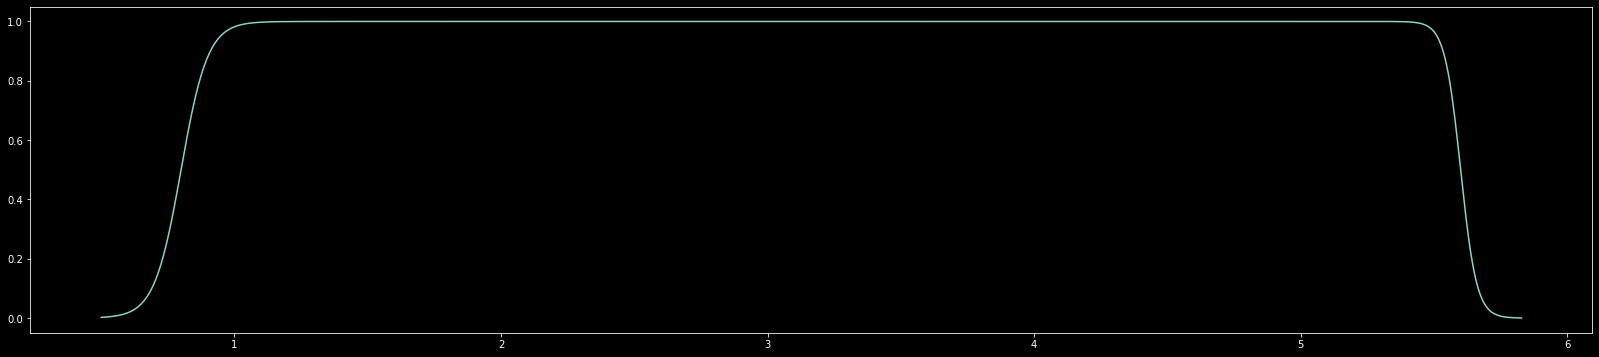

In [ ]:
# armamos una ventana para llevar a cero la senal en los extremos
s0 = expit((t-0.8)/0.05)*expit((5.6-t)/0.03)
plt.plot(t,s0)

In [ ]:
ri_new = np.zeros((1024,10))
for n in range(10):
  ri_new[-ncommon:,n] = ri_all_13[nmaxv[n]-leftm:nmaxv[n]+rightm,n]*s0[nmaxv[n]-leftm:nmaxv[n]+rightm]

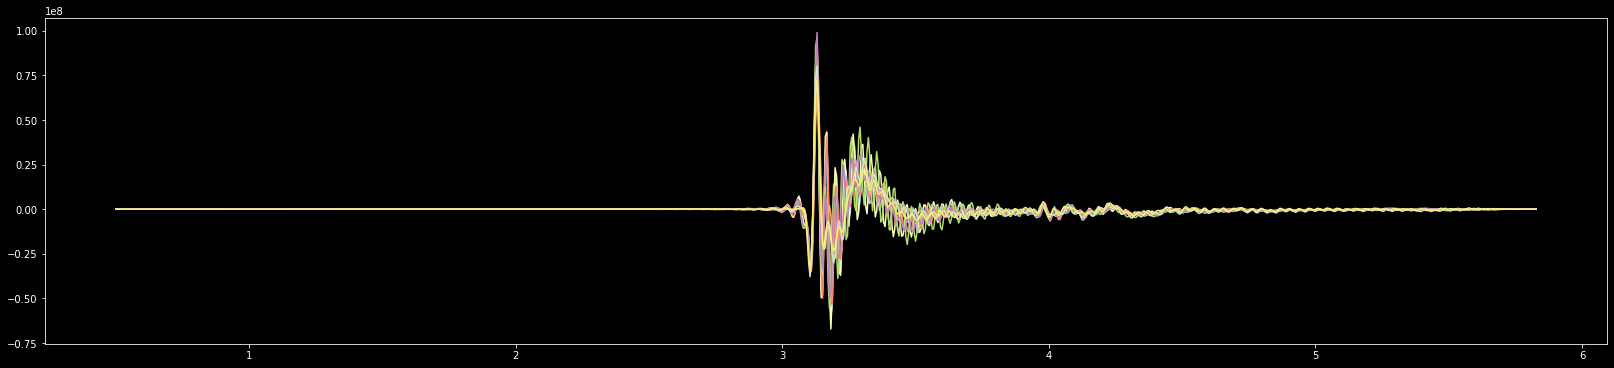

In [ ]:
plt.plot(t,ri_new);

# Aca hacemos el calculo del filtro

Elegimos el parlante de referencia n_ref

In [ ]:
n_ref = 4
cut = 25000
slope = 1000
eps = 1
ff_ref = fft(ri_new[:,n_ref])[:513]
ff_f = np.zeros((1024,10),dtype="complex")
ri_f = np.zeros((1024,10))
fr_f = np.zeros((1024,10),dtype="complex")
f1 = f[:513]
s1 = expit((cut-f1)/slope)
for n in range(10):
  ff0 = fft(ri_new[:,n])[:513]
  ff_f[:513,n] = s1*ff_ref/(ff0+eps)
  ff_f[513:,n] = np.conj(ff_f[np.arange(511,0,-1),n])
  ri_f[:,n] = np.real(ifft(ff_f[:,n]))
  fr_f[:,n] = fft(ri_new[:,n])*ff_f[:,n]

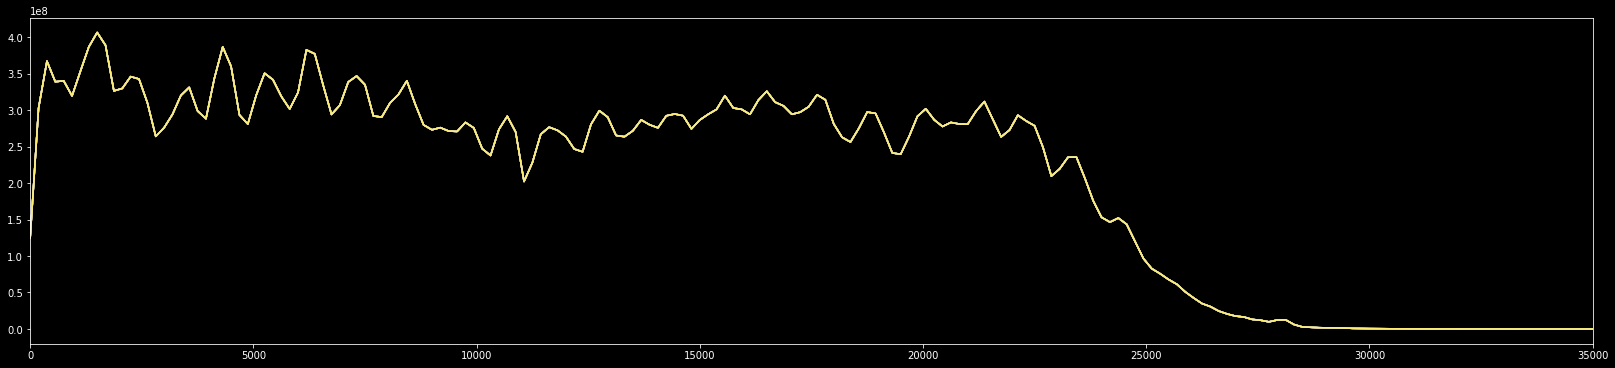

In [ ]:
plt.plot(f,np.abs(fr_f));
plt.xlim([0,35000]);

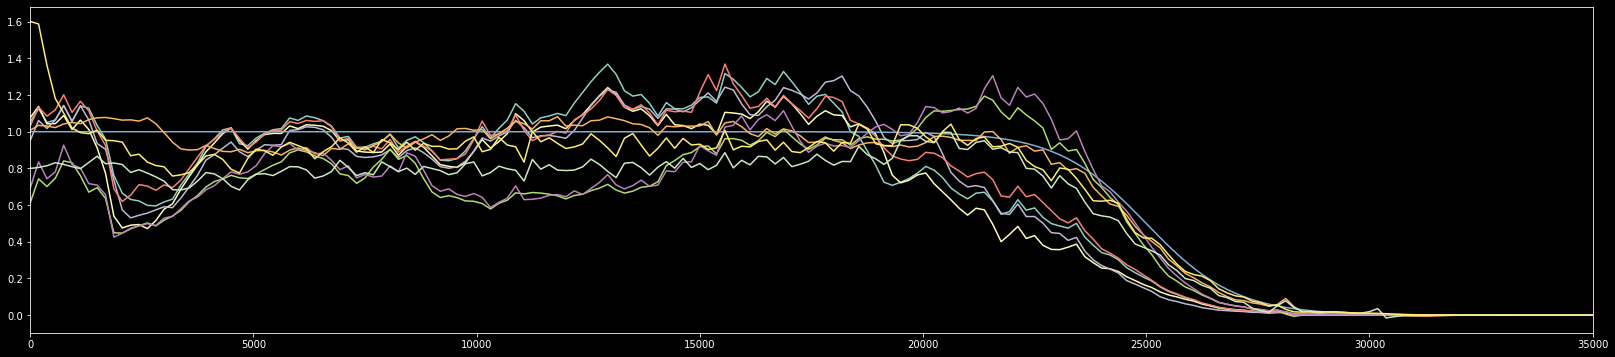

In [ ]:
plt.plot(f,np.real(ff_f));
plt.xlim([0,35000]);

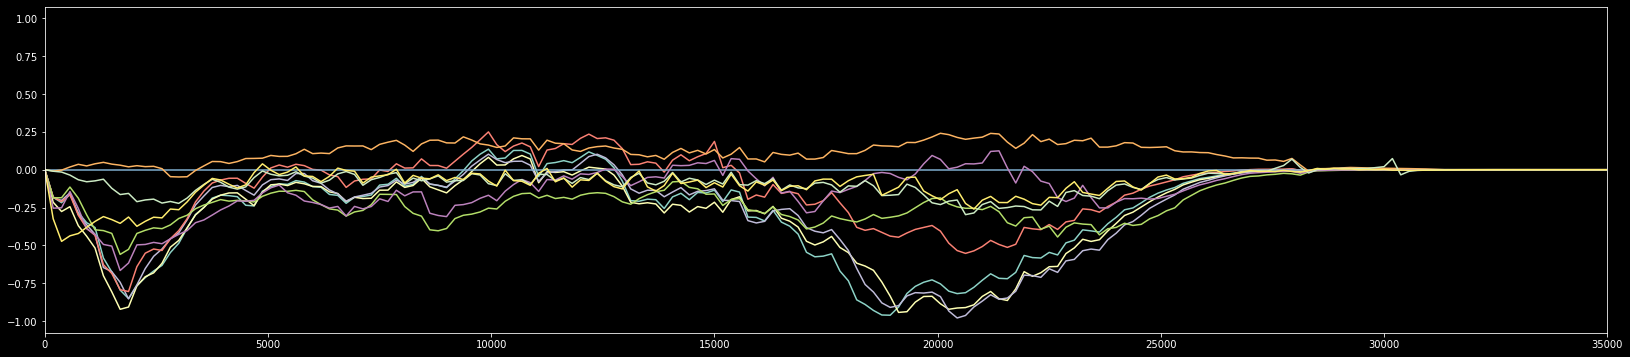

In [ ]:
plt.plot(f,np.imag(ff_f));
plt.xlim([0,35000]);

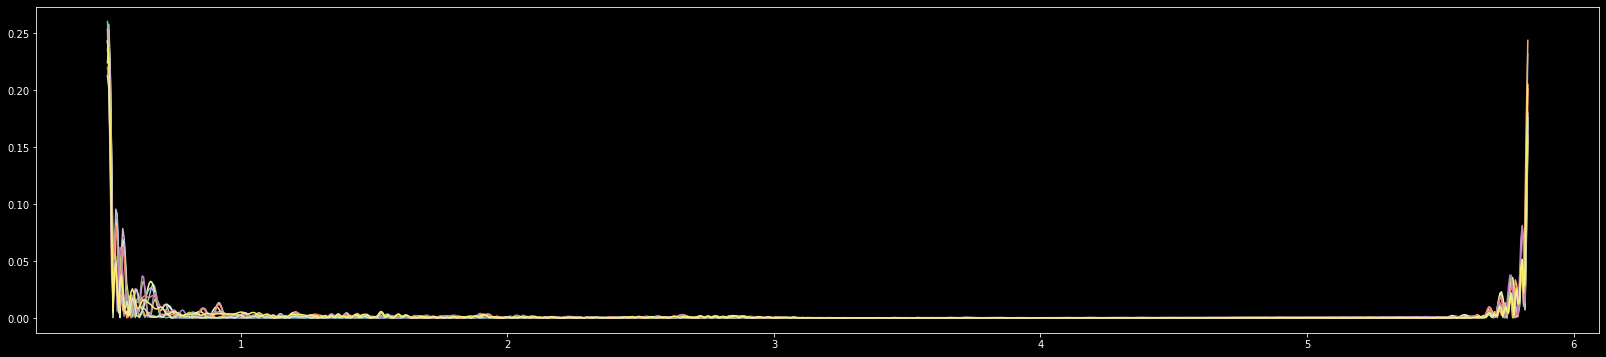

In [ ]:
plt.plot(t,np.abs(ri_f));

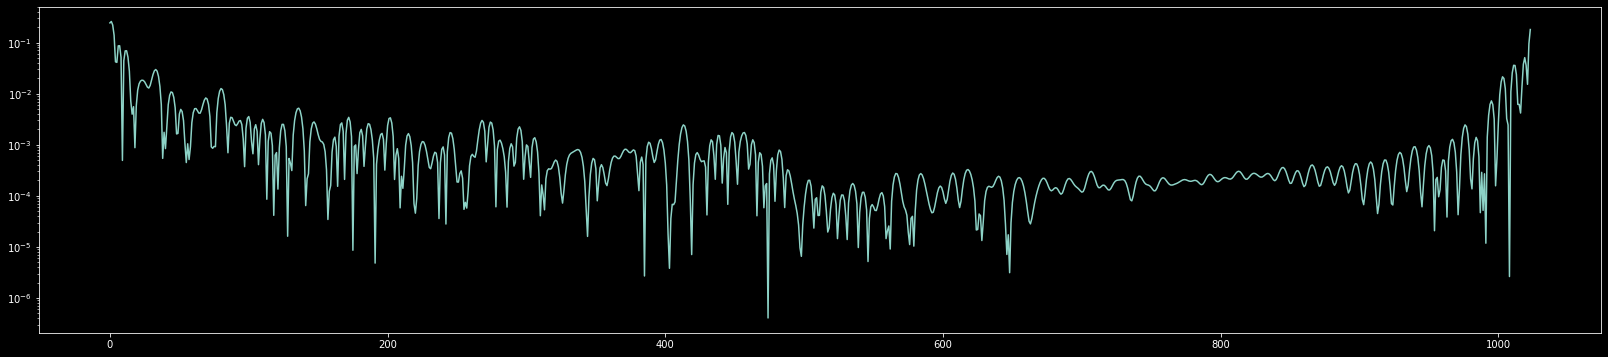

In [ ]:
plt.semilogy(np.abs(ri_f[:,0]))

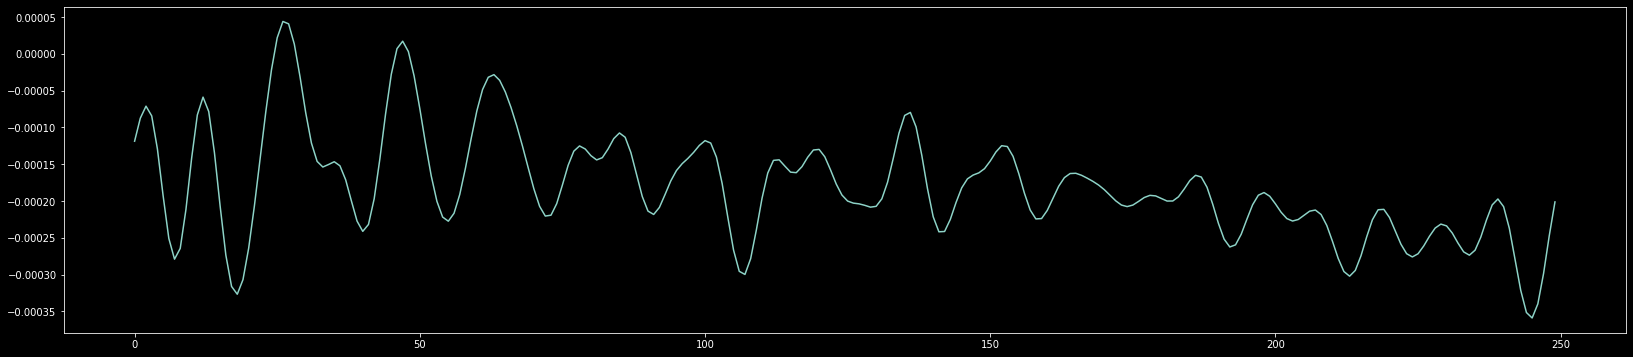

In [ ]:
plt.plot(ri_f[600:850,0])

In [ ]:
ri_f[640:650,0]

array([-2.41125805e-04, -2.31774534e-04, -1.96879589e-04, -1.42645522e-04,
       -8.15090719e-05, -2.77451083e-05,  7.11128006e-06,  1.72430780e-05,
        3.12522647e-06, -2.99447326e-05])

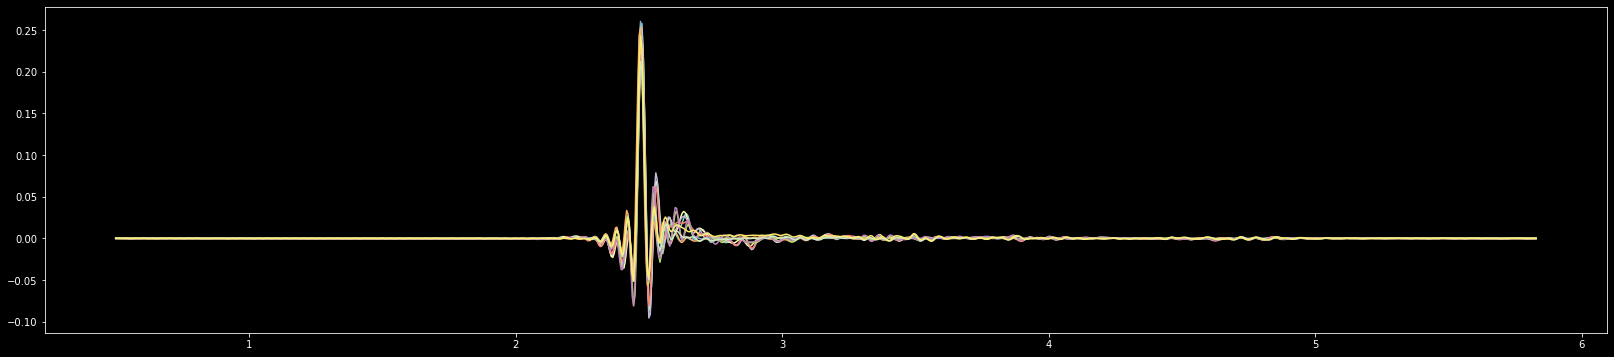

In [ ]:
ri_f2 = np.vstack([ri_f[646:,:],ri_f[:646,:]])
plt.plot(t,ri_f2);

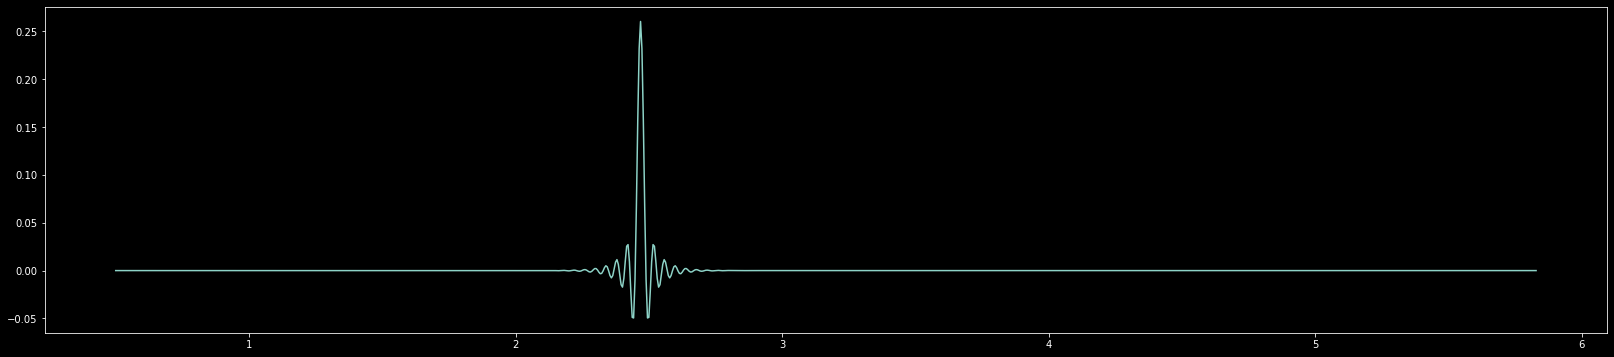

In [ ]:
# Atencion  este es el filtros inverso del propio parlante que tiene la atenuacion por arriba de 25 kHz, no deberia producir ningun cambio audible
plt.plot(t,ri_f2[:,4])

In [ ]:
np.save(rpath + 'ri_f2.npy',ri_f2)

# PENDIENTE

In [ ]:
# Distorsion Armonica


#np.save(rpath + 'ri_all.npy',ri_all)

In [ ]:
from scipy import signal
from scipy.io import wavfile

def multitone(T, N=28,f1=40, f2=20480,filename=None,fs=48000,rms=-3.0):
    fn=np.logspace(np.log10(f1),np.log10(f2),N)
    t = np.arange(T*fs)/fs
    phi = +np.random.rand(N)
    multi = t*0
    for n,f in enumerate(fn):
        multi += np.sin(2*np.pi*f*t+phi[n])
    rms_multi = 10.0*np.log10(np.mean(np.square(multi))) # deberia ser -3 dB
    rms_diff = rms - rms_multi
    if (rms_diff<0):
        multi = multi*np.power(10.0,rms_diff/20.0) # ajusta la rams
    else:
        print('Warning RMS pedido mayor al RMS de corte que es {0:.2f} dB '.format(rms_multi))  
    rms_multi = 10*np.log10(np.mean(np.square(multi)))
    print('Multi RMS = {0:.2f} dB '.format(rms_multi))
    Nfade = int(0.05*fs)   
    w = signal.hann(2*Nfade) # ventana para fadein
    multi[:Nfade] = multi[:Nfade]*w[:Nfade]
    multi[-Nfade:] = multi[-Nfade:]*w[-Nfade:] 
    wavfile.write(filename + '.wav',fs,multi)     
    return multi